# 投资组合

In [1]:
import yfinance as yf

In [2]:
tickers = {
    '^SSE50':'上证50',
    '600519.SS':'贵州茅台',
    '518880.SS':'黄金ETF'
}

data = yf.download(list(tickers), period='3y')['Close']
data.rename(columns=tickers, inplace=True)
data.head()

[*********************100%***********************]  3 of 3 completed


,黄金ETF,贵州茅台,上证50
Date,,,
2017-06-12,2.770,472.880005,2521.169922
2017-06-13,2.775,473.040009,2515.139893
2017-06-14,2.782,474.390015,2477.320068
2017-06-15,2.759,464.299988,2461.969971
2017-06-16,2.755,462.630005,2452.790039


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font='Arial Unicode MS', rc={'figure.figsize':(10, 6)})

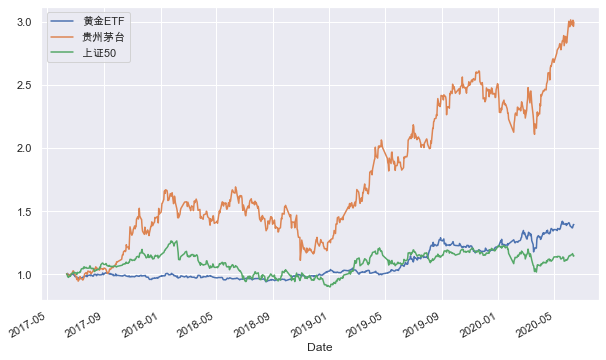

In [4]:
(data / data.iloc[0]).plot()

## 收益

$$ r = \ln \frac{p_t}{p_{t-1}} $$

In [5]:
import numpy as np

r_log = np.log(data / data.shift(1))
r_log.head()

,黄金ETF,贵州茅台,上证50
Date,,,
2017-06-12,NaN,NaN,NaN
2017-06-13,0.001803,0.000338,-0.002395
2017-06-14,0.002519,0.002850,-0.015151
2017-06-15,-0.008302,-0.021499,-0.006216
2017-06-16,-0.001451,-0.003603,-0.003736


$$ r = \frac{p_t - p_{t-1}}{p_{t-1}} = \frac{p_t}{p_{t-1}} - 1 $$

In [6]:
r_annual = np.exp(r_log.mean() * 250) - 1
r_annual

黄金ETF    0.119575
贵州茅台     0.455246
上证50     0.047072
dtype: float64

## 风险

In [7]:
std = np.sqrt(r_log.var() * 250)
std

黄金ETF    0.123093
贵州茅台     0.324742
上证50     0.196196
dtype: float64

## 组合的收益与风险

In [8]:
def gen_weights(n):
    w = np.random.rand(n)
    return w / np.sum(w)

n = len(list(tickers))

w = gen_weights(n)

In [9]:
list(zip(r_annual.index, w))

[('黄金ETF', 0.3722682552597212),
 ('贵州茅台', 0.349331723383114),
 ('上证50', 0.2784000213571648)]

$$ \mu_p = \sum_{i=1}^{n} w_i \mu_i $$

In [10]:
def port_ret(w):
    return np.sum(w * r_annual)

port_ret(w)

0.21665066228596983

$$ \sigma^2=\sum_{i=1}^{n}\sum_{j=1}^{n}w_i w_j cov(r_i, r_j) = w^T \Sigma w $$

In [11]:
def port_std(w):
    return np.sqrt(w.T.dot((r_log.cov()*250).dot(w)))

port_std(w)

0.15701090030927065

In [12]:
def gen_ports(times):
    for _ in range(times):
        w = gen_weights(n)
        yield (port_std(w), port_ret(w), w)
        
import pandas as pd

df = pd.DataFrame(gen_ports(3000), columns=['std', 'ret', 'w'])
df.head()

,std,ret,w
0,0.151436,0.231522,"[0.4532359399274138, 0.371383147534333, 0.1753..."
1,0.201279,0.177317,"[0.06176263249863565, 0.3081214255844515, 0.63..."
2,0.114709,0.176245,"[0.6292547141252127, 0.20469130437845576, 0.16..."
3,0.137363,0.239364,"[0.63319759512417, 0.35862820014479946, 0.0081..."
4,0.216800,0.238579,"[0.07672384069360137, 0.4555511826733519, 0.46..."


$$ SharpeRatio=\frac{r_p - r_f}{\sigma_p} $$

In [13]:
df['sharpe'] = (df['ret'] - 0.03) / df['std']

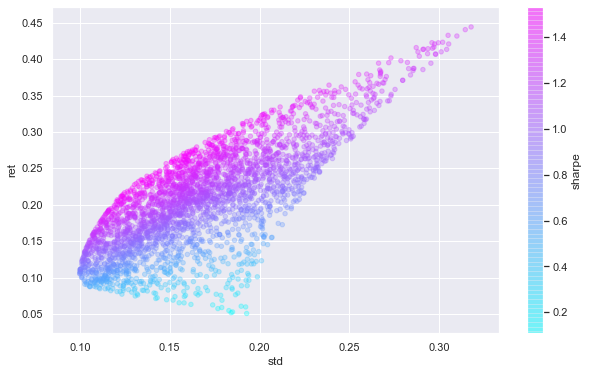

In [14]:
fig, ax = plt.subplots()
df.plot.scatter('std', 'ret', c='sharpe', alpha=0.3, cmap='cool', ax=ax)

In [16]:
import scipy.optimize as opt

frontier = pd.DataFrame(columns=['std', 'ret'])

for std in np.linspace(0, .35):
    res = opt.minimize(lambda x: -port_ret(x),
                 x0 = ((1 / n),) * n,
                 method='SLSQP',
                 bounds=((0, 1),) * n,
                 constraints=[
                     {'fun': lambda x: port_std(x) - std, 'type':'eq'},
                     {'fun': lambda x: np.sum(x) - 1, 'type':'eq'}
                 ])
    if res.success:
        frontier = frontier.append({'std': std, 'ret': -res.fun}, ignore_index=True)
        
frontier.plot('std', 'ret', lw=3, ax=ax)

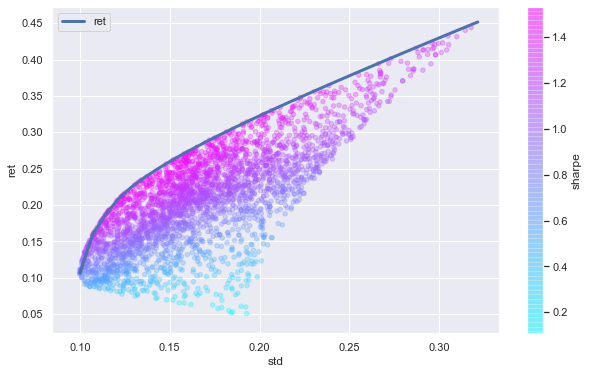

In [17]:
fig

In [18]:
res = opt.minimize(lambda x: -(port_ret(x) - .03) / port_std(x),
                 x0 = ((1 / n),) * n,
                 method='SLSQP',
                 bounds=((0, 1),) * n,
                 constraints={'fun': lambda x: np.sum(x) - 1, 'type':'eq'})

res.x.round(2)

array([0.61, 0.39, 0.  ])

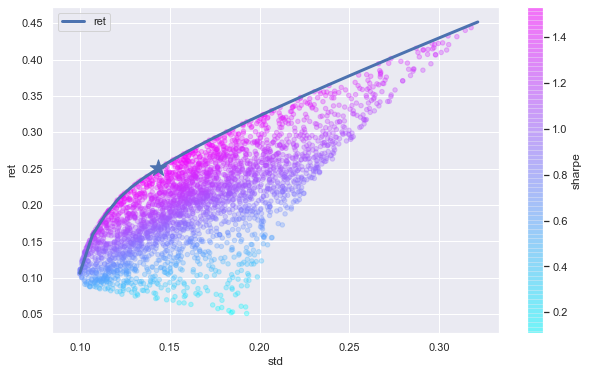

In [19]:
ax.scatter(port_std(res.x), port_ret(res.x), marker='*', s=300)
fig

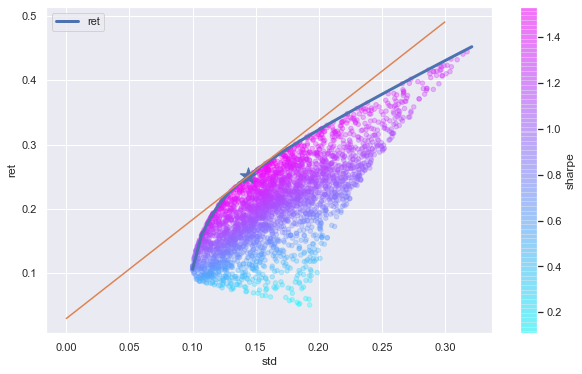

In [20]:
ax.plot((0, .3), (.03, -res.fun * .3 + .03))
fig